In [3]:
import re

### Création de la liste de mots-clés haineux

In [2]:
with open("kw_hate.txt", "r") as f:
    kw = f.read().splitlines()

### Analyse des clusters issus du premier clustering (encodage embedding)
- On itère sur chaque méthode de nettoyage et de clustering
- Pour chaque couple de méthodes on analyse le fichier `clusters_info` correspondant
- On affiche le numéro de cluster, le nombre de messages et le pourcentage de messages haineux pour chaque cluster qui :
  - contient au moins 10% de messages contenant un mot-clé haineux
  - ou bien a un mot-clé haineux dans les mots les plus proches de son centre

In [4]:
for clean_method in ["MinStp", "Std", "Lem"]:
    for clust_method in ["km_25", "km_50", "km_100", "som_100", "som_225", "som_400"]:
        dir = "clusters/1M_{}_clusters/{}/".format(clean_method, clust_method)
        filename = clust_method + "_clusters_info.txt"
        print("{} + {}".format(clean_method, clust_method))
        with open(dir + filename, "r") as f:
            lines = f.read().split("\n\n")
        for i, line in enumerate(lines):
            res = re.findall("(\d*\.\d*)%", line)
            n_msg_res = re.findall("(\d*) messages", line)
            if (len(n_msg_res) > 0):
                n_msg = int(n_msg_res[0])
            c = re.findall("centre : .*", line)
            if (len(c) > 0):
                center = c[0][9:]
            if (len(res) > 0):
                num = float(res[0])
            if (num > 3 or any(item in center for item in kw)):
                print("Cluster {} ({} messages) : {}% de messages contiennent un mot haineux".format(i, n_msg, num))
        print()

MinStp + km_25

MinStp + km_50
Cluster 27 (1712 messages) : 0.41% de messages contiennent un mot haineux

MinStp + km_100
Cluster 22 (1515 messages) : 0.33% de messages contiennent un mot haineux
Cluster 23 (1616 messages) : 0.31% de messages contiennent un mot haineux
Cluster 30 (33398 messages) : 1.48% de messages contiennent un mot haineux
Cluster 36 (7784 messages) : 7.17% de messages contiennent un mot haineux
Cluster 59 (1122 messages) : 4.01% de messages contiennent un mot haineux
Cluster 70 (1532 messages) : 1.96% de messages contiennent un mot haineux
Cluster 83 (1670 messages) : 1.02% de messages contiennent un mot haineux
Cluster 94 (3243 messages) : 5.49% de messages contiennent un mot haineux

MinStp + som_100
Cluster 29 (5647 messages) : 4.55% de messages contiennent un mot haineux
Cluster 74 (2186 messages) : 4.3% de messages contiennent un mot haineux
Cluster 76 (2468 messages) : 0.61% de messages contiennent un mot haineux
Cluster 77 (2463 messages) : 1.02% de messages

### Analyse du deuxième clustering (2e dataset, encodage transformers)

On cherche a déterminer le nombre de clusters qui donne les meilleurs résultats, ainsi que le curseur à utiliser (voir plus bas)

In [1]:
filename_format = "clusters/bert_clusters_{htype}/{htype}_bertsom{n_clust}/{htype}_bertsom{n_clust}_clusters_info.txt"

- On itère sur les différentes types et les deux nombres de clusters.
- Pour chaque type et nombre de clusters on compte le nombre de messages gardés (issus de clusters ayant plus de 80% ou moins de 20% de messages haineux)

In [10]:
goods = {'36' : [], '49' : []}
tots = {'36' : [], '49' : []}
count = {'36' : [], '49' : []}

pmax, pmin = 90, 10

print("type    \tn_clust\tgardés/total\t%gardés")

for ht in ['africain', 'antisemite', 'arabe', 'capacitiste', 'chretien', 'gitan', 'miso', 'musulman']:
    for nc in ['36', '49']:
        with open(filename_format.format(htype=ht, n_clust=nc), "r") as f:
            lines = f.read().split('\n\n')
        tot, good, h, n = 0, 0, 0, 0
        for line in lines[:-1]: 
            n_msg = int(re.findall(' (\d*) messages' , line)[0])
            hper = re.findall('(\d*.\d*)% de', line)
            hper = float(hper[0]) if len(hper) > 0 else 0    
            tot += n_msg
            good += n_msg if hper >= pmax or hper <= pmin else 0
            h += n_msg if hper >= pmax else 0
            n += n_msg if hper <= pmin else 0
        t = ht + "    " if len(ht) < 8 else ht
        print("{}\t{} :\t{} / {}\t= {:.2f}".format(t, nc, good, tot, good/tot*100))
        goods[nc].append(good)
        tots[nc].append(tot)   
        count[nc].append((h, n))
        
per_garde_36 = sum([g for g in goods['36']]) / sum([t for t in tots['36']]) * 100
per_garde_49 = sum([g for g in goods['49']]) / sum([t for t in tots['49']]) * 100
print("\nTotal :\n36 cluster :\t {:.2f}% gardés\n49 clusters :\t {:.2f}% gardés".format(per_garde_36, per_garde_49))

type    	n_clust	gardés/total	%gardés
africain	36 :	1428 / 6147	= 23.23
africain	49 :	1092 / 6147	= 17.76
antisemite	36 :	323 / 1656	= 19.50
antisemite	49 :	455 / 1656	= 27.48
arabe    	36 :	2306 / 10256	= 22.48
arabe    	49 :	2193 / 10256	= 21.38
capacitiste	36 :	1356 / 10008	= 13.55
capacitiste	49 :	2179 / 10008	= 21.77
chretien	36 :	1133 / 5808	= 19.51
chretien	49 :	1135 / 5808	= 19.54
gitan    	36 :	112 / 5047	= 2.22
gitan    	49 :	329 / 5047	= 6.52
miso    	36 :	2505 / 10503	= 23.85
miso    	49 :	2740 / 10503	= 26.09
musulman	36 :	583 / 5303	= 10.99
musulman	49 :	865 / 5303	= 16.31

Total :
36 cluster :	 17.81% gardés
49 clusters :	 20.08% gardés


On garde plus de messages avec 49 clusters qu'avec 36

On regarde l'équilibrage : le nombre de messages haineux / non haineux par type et par nombre de cluster et on calcule le pourcentage total

In [56]:
print("36 clusters :")
for tup, htype in zip(count['36'], ['africain', 'antisemite', 'arabe   ', 'capacitiste', 'chretien', 'gitan   ', 'miso    ', 'musulman']):
    print("{} :\t {} haineux \t/\t{} normaux".format(htype, tup[0], tup[1]))
somme = sum([c[0] for c in count['36']]), sum([c[1] for c in count['36']])
print("total  :\t {} haineux \t/\t{} normaux".format(somme[0], somme[1]))
print("rapport :\t {:.2f}% haineux \t/\t {:.2f}% normaux".format(somme[0]/(somme[0] + somme[1]), somme[1]/(somme[0] + somme[1]))) 
print("\n49 clusters :")
for tup, htype in zip(count['49'], ['africain', 'antisemite', 'arabe   ', 'capacitiste', 'chretien', 'gitan   ', 'miso    ', 'musulman']):
    print("{} :\t {} haineux \t/\t{} normaux".format(htype, tup[0], tup[1]))
somme = sum([c[0] for c in count['49']]), sum([c[1] for c in count['49']])
print("total  :\t {} haineux \t/\t{} normaux".format(somme[0], somme[1]))
print("rapport :\t {:.2f}% haineux \t/\t {:.2f}% normaux".format(somme[0]/(somme[0] + somme[1]), somme[1]/(somme[0] + somme[1]))) 

36 clusters :
africain :	 699 haineux 	/	729 normaux
antisemite :	 314 haineux 	/	9 normaux
arabe    :	 2087 haineux 	/	219 normaux
capacitiste :	 1356 haineux 	/	0 normaux
chretien :	 381 haineux 	/	752 normaux
gitan    :	 11 haineux 	/	101 normaux
miso     :	 2505 haineux 	/	0 normaux
musulman :	 0 haineux 	/	583 normaux
total  :	 7353 haineux 	/	2393 normaux
rapport :	 0.75% haineux 	/	 0.25% normaux

49 clusters :
africain :	 484 haineux 	/	608 normaux
antisemite :	 446 haineux 	/	9 normaux
arabe    :	 1975 haineux 	/	218 normaux
capacitiste :	 1955 haineux 	/	224 normaux
chretien :	 139 haineux 	/	996 normaux
gitan    :	 116 haineux 	/	213 normaux
miso     :	 2692 haineux 	/	48 normaux
musulman :	 0 haineux 	/	865 normaux
total  :	 7807 haineux 	/	3181 normaux
rapport :	 0.71% haineux 	/	 0.29% normaux


On observe un équilibrage un peu meilleur avec 49 clusters qu'avec 36

In [47]:
ht = 'miso'
nc = '100'

with open(filename_format.format(htype=ht, n_clust=nc), "r") as f:
    lines = f.read().split('\n\n')
tot, good, h, n = 0, 0, 0, 0
for line in lines[:-1]: 
    n_msg = int(re.findall(' (\d*) messages' , line)[0])
    hper = re.findall('(\d*.\d*)% de', line)
    hper = float(hper[0]) if len(hper) > 0 else 0    
    tot += n_msg
    good += n_msg if hper >= 80 or hper <= 20 else 0
    h += n_msg if hper >= 80 else 0
    n += n_msg if hper <= 20 else 0
    t = ht + "    " if len(ht) < 8 else ht
print("{}\t{} :\t{} / {}\t= {}".format(t, nc, good, tot, good/tot))
print("gardés : {} haineux / {} normaux".format(h, n))

miso    	100 :	5493 / 10503	= 0.5229934304484433
gardés : 4651 haineux / 842 normaux


Avec 100 clusters on garde plus de 50% des messages sur le jeu de données misogyne

In [67]:
4651 / (4651 + 842)

0.8467139996359002

Mais il reste très déséquilibré avec 84% de messages haineux

### Déterminer le curseur

Le curseur représente la limite de pourcentage de messages de haineux ou non haineux pour retenir un cluster.
Un curseur de 15 signifie que l'on garde les cluster dont le pourcentage de messages haineux est inférieur à 15% et supérieur
à 85% (soit 15% de messages non haineux).

In [12]:
import matplotlib.pyplot as plt
gspread = { '36' : [], '49' : [] }
counts = { '36' : [], '49' : [] }
for gap in range(1, 51):
    pmax = 100 - gap
    pmin = gap
    count = {'36' : [], '49' : []}
    for ht in ['africain', 'antisemite', 'arabe', 'capacitiste', 'chretien', 'gitan', 'miso', 'musulman']:
        for nc in ['36', '49']:
            with open(filename_format.format(htype=ht, n_clust=nc), "r") as f:
                lines = f.read().split('\n\n')
            tot, good, h, n = 0, 0, 0, 0
            for line in lines[:-1]: 
                n_msg = int(re.findall(' (\d*) messages' , line)[0])
                hper = re.findall('(\d*.\d*)% de', line)
                hper = float(hper[0]) if len(hper) > 0 else 0    
                tot += n_msg
                good += n_msg if hper >= pmax or hper <= pmin else 0
                h += n_msg if hper >= pmax else 0
                n += n_msg if hper <= pmin else 0
            count[nc].append((h, n))
    sh, sn = sum([c[0] for c in count['36']]), sum([c[1] for c in count['36']])
    gspread['36'].append(abs(sh-sn) / (sh+sn))
    counts['36'].append(sh + sn)
    sh, sn = sum([c[0] for c in count['49']]), sum([c[1] for c in count['49']])
    gspread['49'].append(abs(sh-sn) / (sh+sn))
    counts['49'].append(sh + sn)

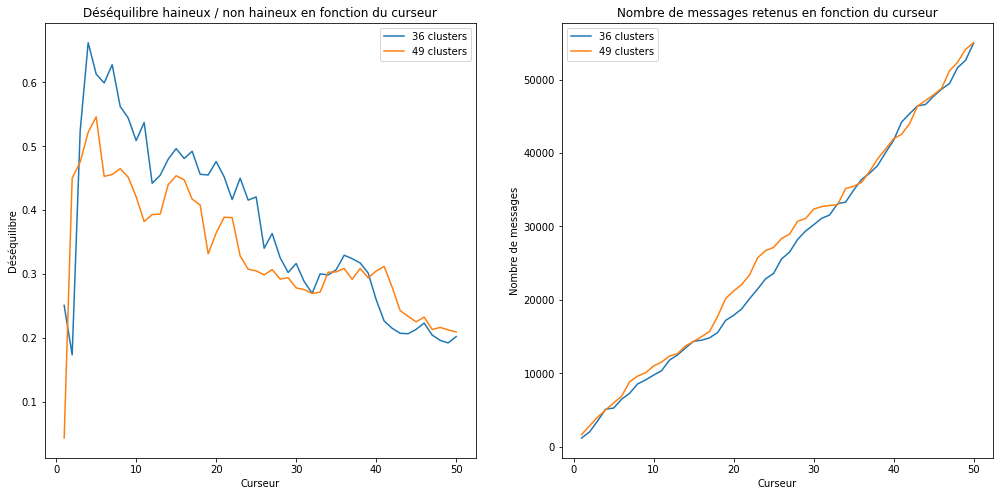

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(17,8))
a = axs[0]
b = axs[1]
a.plot(range(1, 51), gspread['36'], label='36 clusters')
a.plot(range(1, 51), gspread['49'], label='49 clusters')
a.legend()
a.set(title="Déséquilibre haineux / non haineux en fonction du curseur")
a.set_xlabel("Curseur")
a.set_ylabel("Déséquilibre")
b.plot(range(1, 51), counts['36'], label='36 clusters')
b.plot(range(1, 51), counts['49'], label='49 clusters')
b.set(title="Nombre de messages retenus en fonction du curseur")
b.set_xlabel("Curseur")
b.set_ylabel("Nombre de messages")
a = b.legend()

### Déterminer les clusters prometteurs et le label associé par type
Pour la constitution du dataset final

In [16]:
filename_format = "clusters/bert_clusters_{htype}/{htype}_bertsom49/{htype}_bertsom49_clusters_info.txt"

lab_clust_utiles_par_type = {}

for ht, ft in zip(['africain', 'antisemite', 'arabe', 'capacitiste', 'chretien', 'gitan', 'miso', 'musulman'],
                  ['afro', 'antis', 'arabe', 'capa', 'chret', 'gitan', 'miso', 'mus']):
    with open(filename_format.format(htype=ht), "r") as f:
        lines = f.read().split('\n\n')
    pourcentage_haineux = {}
    for line in lines[:-1]: 
        n_clust = int(re.findall('Cluster (\d*)', line)[0])
        hper = re.findall('(\d*.\d*)% de', line)
        hper = float(hper[0]) if len(hper) > 0 else 0
        if hper >= 80 or hper <= 20:
            pourcentage_haineux[n_clust] = 1 if hper>=80 else 0 
    lab_clust_utiles_par_type[ft] = dict(pourcentage_haineux)

In [21]:
for htype, clusters in lab_clust_utiles_par_type.items():
    print(htype)
    for n, lab in clusters.items():
        print("Cluster {} : {}".format(n, "haineux" if lab == 1 else "non haineux"))
    print()

afro
Cluster 1 : non haineux
Cluster 3 : non haineux
Cluster 4 : haineux
Cluster 9 : non haineux
Cluster 11 : haineux
Cluster 12 : haineux
Cluster 13 : non haineux
Cluster 16 : haineux
Cluster 19 : haineux
Cluster 24 : non haineux
Cluster 29 : non haineux
Cluster 33 : haineux
Cluster 34 : haineux
Cluster 44 : non haineux
Cluster 46 : non haineux
Cluster 48 : non haineux

antis
Cluster 1 : haineux
Cluster 2 : haineux
Cluster 7 : haineux
Cluster 8 : haineux
Cluster 13 : haineux
Cluster 22 : haineux
Cluster 23 : haineux
Cluster 25 : non haineux
Cluster 29 : haineux
Cluster 30 : haineux
Cluster 31 : haineux
Cluster 32 : haineux
Cluster 33 : haineux
Cluster 35 : non haineux
Cluster 42 : haineux
Cluster 43 : haineux
Cluster 44 : haineux
Cluster 45 : haineux

arabe
Cluster 4 : haineux
Cluster 5 : haineux
Cluster 6 : haineux
Cluster 8 : haineux
Cluster 11 : haineux
Cluster 14 : haineux
Cluster 15 : haineux
Cluster 16 : haineux
Cluster 17 : haineux
Cluster 18 : haineux
Cluster 21 : haineux
Clus